#### This notebook will be used for the Assignment of week3 of capstone course for Applied Data Science on Coursera


#### Author: Rajiv Ranjan Singh

1. [Assignment Part1](#assign_part1)

2. [Assignment Part2](#assign_part2)

3. [Assignment Part3](#assign_part3)


<a id='assign_part1'></a>

## Assignment Part 1

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
# creating url for scraping data
data_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data_url

'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#### Using pandas to read table from wikipedia page

In [3]:
df=pd.read_html(data_url)

#### Extracting dataframe from the scraped data

In [4]:
df = df[0]
print(type(df))

<class 'pandas.core.frame.DataFrame'>


#### Getting the column names to check extracted dataframe

In [5]:
df.columns

Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')

#### Changing column name 'Postcode' to 'PostalCode' as per assignment requirement 

In [6]:
df.rename(columns = {'Postcode':'PostalCode'},inplace = True)
df.columns

Index(['PostalCode', 'Borough', 'Neighbourhood'], dtype='object')

#### Inspecting the number of rows and columns in df

In [7]:
df.shape

(288, 3)

In [8]:
print( "The number of rows with Borough value being Not Assigned : \n" , (df['Borough']=='Not assigned').value_counts()[1])

The number of rows with Borough value being Not Assigned : 
 77


In [9]:
# assign df to values with Borough not being 'Not assigned'
df = df[df['Borough']!='Not assigned']

#### Inspecting the number of rows and columns in df to ensure rows with Not assigned Borough values have been dropped

In [10]:
df.shape

(211, 3)

#### Assign Borough name to neighbourhoods with 'Not assigned' value

In [11]:
df.loc[df['Neighbourhood']=='Not assigned','Neighbourhood'] = df.loc[df['Neighbourhood']=='Not assigned','Borough']

#### Defining Function that will take unique 'Borough' values and join neighbourhood values sperated by a comma on groupby Dataframe object

In [12]:
def f(x):
    return pd.Series(dict(Borough = x['Borough'].unique()[0],
                       Neighbourhood = "%s" % ','.join(x['Neighbourhood'])))
    

In [13]:
df = df.groupby(by='PostalCode').apply(f).reset_index()

In [14]:
print( "The cleaned dataframe has ",df.shape[0], "rows and ", df.shape[1], " columns.") 

The cleaned dataframe has  103 rows and  3  columns.


In [15]:
df.head()

PostalCode      Borough                         Neighbourhood
0        M1B  Scarborough                         Rouge,Malvern
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union
2        M1E  Scarborough       Guildwood,Morningside,West Hill
3        M1G  Scarborough                                Woburn
4        M1H  Scarborough                             Cedarbrae

<a id = 'assign_part2'></a>

## Assignment Part 2

### Use the Geocoder package or the csv file ( https://cocl.us/Geospatial_data) to create the  dataframe with lat and long:

<img src="files/image.jpg">

In [16]:
# fetchin csv file from the link provided in assignment
url = 'https://cocl.us/Geospatial_data'
df_ll = pd.read_csv(url)
df_ll.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

#### Rename Postal Code column to 'Postcode' to match column name with neighbourhood dataframe df

In [17]:
df_ll.rename(columns = {'Postal Code':'PostalCode'},inplace=True)
df_ll.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

#### Merge df_ll to right of neighbourhood dataframe df using Postcode column as index

In [18]:
df = df.merge(right = df_ll,how = 'left', on = 'PostalCode')
df.head()

PostalCode      Borough                         Neighbourhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3        M1G  Scarborough                                Woburn  43.770992   
4        M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

#### Changing column name from "Postcode" to "PostalCode" to match with dataframe required by assignment

In [19]:
df.rename(columns = {'Postcode':'PostalCode'},inplace=True)
df.head()

PostalCode      Borough                         Neighbourhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3        M1G  Scarborough                                Woburn  43.770992   
4        M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

<a id='assign_part3'></a>

## Assignment Part 3

Assignment Description: Explore and cluster the neighbourhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

### 1. Explore Dataset

In [20]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighbourhoods.


In [21]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [22]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [23]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

CLIENT_ID = '1223456778' # your Foursquare ID
CLIENT_SECRET = '12235453' # your Foursquare Secret
VERSION = '20190927' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Let's explore the first neighbourhood in our dataframe.

Get the neighbourhood's name.

In [24]:
df.loc[0, 'Neighbourhood']

'Rouge,Malvern'

Get the neighbourhood's latitude and longitude values.

In [25]:
neighbourhood_latitude = df.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = df.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = df.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Rouge,Malvern are 43.806686299999996, -79.19435340000001.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL.

In [26]:
LIMIT = 20 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)

In [27]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5da94f01f96b2c002cc2d418'},
 'response': {'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 15,
  'suggestedBounds': {'ne': {'lat': 43.81568630900001,
    'lng': -79.18190576146081},
   'sw': {'lat': 43.797686290999984, 'lng': -79.20680103853921}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d669cba83865481c948fa53',
       'name': 'Images Salon & Spa',
       'location': {'address': '8130 Sheppard Ave E',
        'crossStreet': 'Morningside Ave',
        'lat': 43.80228301948931,
        'lng': -79.19856472801668,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.80228301948931,
          'lng': -79.19856472801668}],
       

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                     categories        lat        lng
0   Images Salon & Spa                            Spa  43.802283 -79.198565
1       Caribbean Wave           Caribbean Restaurant  43.798558 -79.195777
2              Wendy's           Fast Food Restaurant  43.802008 -79.198080
3              Wendy's           Fast Food Restaurant  43.807448 -79.199056
4  Staples Morningside  Paper / Office Supplies Store  43.800285 -79.196607

In [30]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

15 venues were returned by Foursquare.


### 2. Repeat the process for all neighbourhoods in Toronto

#### A function to repeat the same process to all the neighbourhoods

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### The code to run the above function on each neighbourhood and create a new dataframe called *df_venues*.

In [32]:
df_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

#### The size of the resulting dataframe

In [33]:
print(df_venues.shape)
df_venues.head()

(1071, 7)


Neighbourhood  Neighbourhood Latitude  \
0                         Rouge,Malvern               43.806686   
1  Highland Creek,Rouge Hill,Port Union               43.784535   
2       Guildwood,Morningside,West Hill               43.763573   
3       Guildwood,Morningside,West Hill               43.763573   
4       Guildwood,Morningside,West Hill               43.763573   

   Neighbourhood Longitude                            Venue  Venue Latitude  \
0               -79.194353                          Wendy's       43.807448   
1               -79.160497            Royal Canadian Legion       43.782533   
2               -79.188711  Swiss Chalet Rotisserie & Grill       43.767697   
3               -79.188711                G & G Electronics       43.765309   
4               -79.188711                 Big Bite Burrito       43.766299   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.189914           Pizza Place  
3       -79.191537     Electronics Store  
4       -79.190720    Mexican Restaurant

Let's check how many venues were returned for each neighbourhood

In [34]:
df_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                                
Adelaide,King,Richmond                                                  20   
Agincourt                                                                4   
Agincourt North,L'Amoreaux East,Milliken,Steele...                       3   
Albion Gardens,Beaumond Heights,Humbergate,Jame...                      12   
Alderwood,Long Branch                                                    9   
Bathurst Manor,Downsview North,Wilson Heights                           18   
Bayview Village                                                          4   
Bedford Park,Lawrence Manor East                                        20   
Berczy Park                                                             20   
Birch Cliff,Cliffside West                                               4   
Bloordale Gardens,Eringate,Markland Wood,Old Bu...                       7   
Brockton,Exhibition Place,Parkdale Village                              20   
Business Reply Mail Processing Centre 969 Eastern                       16   
CFB Toronto,Downsview East                                               2   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                      17   
Cabbagetown,St. James Town                                              20   
Caledonia-Fairbanks                                                      5   
Canada Post Gateway Processing Centre                                   10   
Cedarbrae                                                                7   
Central Bay Street                                                      20   
Chinatown,Grange Park,Kensington Market                                 20   
Christie                                                                15   
Church and Wellesley                                                    20   
Clairlea,Golden Mile,Oakridge                                           10   
Clarks Corners,Sullivan,Tam O'Shanter                                   11   
Cliffcrest,Cliffside,Scarborough Village West                            2   
Cloverdale,Islington,Martin Grove,Princess Gard...                       1   
Commerce Court,Victoria Hotel                                           20   
Davisville                                                              20   
Davisville North                                                         7   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                      15   
Del Ray,Keelesdale,Mount Dennis,Silverthorn                              4   
Design Exchange,Toronto Dominion Centre                                 20   
Don Mills North                                                          5   
Dorset Park,Scarborough Town Centre,Wexford Hei...                       8   
Dovercourt Village,Dufferin                                             17   
Downsview Central                                                        3   
Downsview Northwest                                                      5   
Downsview West                                                           5   
Downsview,North Park,Upwood Park                                         4   
East Birchmount Park,Ionview,Kennedy Park                                6   
East Toronto                                                             4   
Emery,Humberlea                                                          1   
Fairview,Henry Farm,Oriole                                              20   
First Canadian Place,Underground city                                   20   
Flemingdon Park,Don Mills South                                         20   
Forest Hill North,Forest Hill West                                       4   
Glencairn                                                                5   
Guildwood,Morningside,West Hill                                          7   
Harbord,University of Toronto                                           20

#### Let's find out how many unique categories can be curated from all the returned venues

In [35]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 218 uniques categories.


### 3. Analyze Each Neighborhood

In [36]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighbourhood'] = df_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

Neighbourhood  Accessories Store  Airport  \
0                         Rouge,Malvern                  0        0   
1  Highland Creek,Rouge Hill,Port Union                  0        0   
2       Guildwood,Morningside,West Hill                  0        0   
3       Guildwood,Morningside,West Hill                  0        0   
4       Guildwood,Morningside,West Hill                  0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Art Gallery  Arts & Crafts Store  \
0                 0                    0            0                    0   
1                 0                    0            0                    0   
2                 0                    0            0                    0   
3                 0                    0            0                    0   
4                 0                    0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0                 0                   0            0              0   
1                 0                   0            0              0   
2                 0                   0            0              0   
3                 0                   0            0              0   
4                 0                   0            0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    1               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Basketball Court  Beer Bar  Beer Store  Bike Shop  Bistro  Board Shop  \
0                 0         0           0          0       0           0   
1                 0         0           0          0       0           0   
2                 0         0           0          0       0           0   
3                 0         0           0          0       0           0   
4                 0         0           0          0       0           0   

   Boat or Ferry  Bookstore  Boutique  Breakfast Spot  Brewery  Bridal Shop  \
0              0          0         0               0        0            0   
1              0          0         0               0        0            0   
2              0          0         0               0        0            0   
3              0          0         0               0        0            0   
4              0          0         0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1                0         0             0              0         0   
2                0         0             0              0         0   
3                0         0             0              0         0   
4                0         0             0              0         0   

   Bus Station  Bus Stop  Butcher  Café  Cajun / Creole Restaurant  \
0            0         0        0     0                          0   
1            0         0        0     0                          0   
2            0         0        0     0                          0   
3            0         0        0     0                          0   
4            0         0        0     0                          0   

   Candy Store  Caribbean Restaurant  C

And let's examine the new dataframe size.

In [37]:
df_onehot.shape

(1071, 219)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
df_grouped = df_onehot.groupby('Neighbourhood').mean().reset_index()
df_grouped

Neighbourhood  Accessories Store  \
0                              Adelaide,King,Richmond           0.000000   
1                                           Agincourt           0.000000   
2   Agincourt North,L'Amoreaux East,Milliken,Steel...           0.000000   
3   Albion Gardens,Beaumond Heights,Humbergate,Jam...           0.000000   
4                               Alderwood,Long Branch           0.000000   
5       Bathurst Manor,Downsview North,Wilson Heights           0.000000   
6                                     Bayview Village           0.000000   
7                    Bedford Park,Lawrence Manor East           0.000000   
8                                         Berczy Park           0.000000   
9                          Birch Cliff,Cliffside West           0.000000   
10  Bloordale Gardens,Eringate,Markland Wood,Old B...           0.000000   
11         Brockton,Exhibition Place,Parkdale Village           0.000000   
12  Business Reply Mail Processing Centre 969 Eastern           0.000000   
13                         CFB Toronto,Downsview East           0.000000   
14  CN Tower,Bathurst Quay,Island airport,Harbourf...           0.000000   
15                         Cabbagetown,St. James Town           0.000000   
16                                Caledonia-Fairbanks           0.000000   
17              Canada Post Gateway Processing Centre           0.000000   
18                                          Cedarbrae           0.000000   
19                                 Central Bay Street           0.000000   
20            Chinatown,Grange Park,Kensington Market           0.000000   
21                                           Christie           0.000000   
22                               Church and Wellesley           0.000000   
23                      Clairlea,Golden Mile,Oakridge           0.000000   
24              Clarks Corners,Sullivan,Tam O'Shanter           0.000000   
25      Cliffcrest,Cliffside,Scarborough Village West           0.000000   
26  Cloverdale,Islington,Martin Grove,Princess Gar...           0.000000   
27                      Commerce Court,Victoria Hotel           0.000000   
28                                         Davisville           0.000000   
29                                   Davisville North           0.000000   
30  Deer Park,Forest Hill SE,Rathnelly,South Hill,...           0.000000   
31        Del Ray,Keelesdale,Mount Dennis,Silverthorn           0.000000   
32            Design Exchange,Toronto Dominion Centre           0.000000   
33                                    Don Mills North           0.000000   
34  Dorset Park,Scarborough Town Centre,Wexford He...           0.000000   
35                        Dovercourt Village,Dufferin           0.000000   
36                                  Downsview Central           0.000000   
37                                Downsview Northwest           0.000000   
38                                     Downsview West           0.000000   
39                   Downsview,North Park,Upwood Park           0.000000   
40          East Birchmount Park,Ionview,Kennedy Park           0.000000   
41                                       East Toronto           0.000000   
42                                    Emery,Humberlea           0.000000   
43                         Fairview,Henry Farm,Oriole           0.000000   
44              First Canadian Place,Underground city           0.000000   
45                    Flemingdon Park,Don Mills South           0.000000   
46                 Forest Hill North,Forest Hill West           0.000000   
47                                          Glencairn           0.000000   
48                    Guildwood,Morningside,West Hill           0.000000   
49                      Harbord,University of Toronto           0.000000   
50    Harbourfront East,Toronto Islands,Union Station           0.000000   
51                           Harbourfront,Regent Park           0.000000   
52          

#### Let's confirm the new size

In [39]:
df.shape

(103, 5)

#### Let's print each neighborhood along with the top 5 most common venues

In [40]:
num_top_venues = 5

for hood in df_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
                  venue  freq
0      Asian Restaurant  0.10
1            Steakhouse  0.10
2  Gym / Fitness Center  0.05
3                   Bar  0.05
4          Concert Hall  0.05


----Agincourt----
            venue  freq
0          Lounge  0.25
1  Breakfast Spot  0.25
2  Clothing Store  0.25
3    Skating Rink  0.25
4           Motel  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
            venue  freq
0      Playground  0.33
1     Coffee Shop  0.33
2            Park  0.33
3   Movie Theater  0.00
4  Massage Studio  0.00


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
                  venue  freq
0         Grocery Store  0.17
1              Pharmacy  0.08
2           Video Store  0.08
3   Japanese Restaurant  0.08
4  Fast Food Restaurant  0.08


----Alderwood,Long Branch----
            venue  freq
0     Pizza Place  0.22
1        Pharmacy  0.11
2     Coffee Shop  0

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = df_grouped['Neighbourhood']

for ind in np.arange(df_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue  \
0                             Adelaide,King,Richmond      Asian Restaurant   
1                                          Agincourt        Breakfast Spot   
2  Agincourt North,L'Amoreaux East,Milliken,Steel...           Coffee Shop   
3  Albion Gardens,Beaumond Heights,Humbergate,Jam...         Grocery Store   
4                              Alderwood,Long Branch           Pizza Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0            Steakhouse          Neighborhood             Speakeasy   
1        Clothing Store          Skating Rink                Lounge   
2                  Park            Playground           Yoga Studio   
3          Liquor Store            Beer Store        Sandwich Place   
4                   Gym                  Pool          Skating Rink   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                  Café                   Bar                 Hotel   
1           Yoga Studio    Dim Sum Restaurant  Ethiopian Restaurant   
2      Department Store  Ethiopian Restaurant   Empanada Restaurant   
3   Japanese Restaurant   Fried Chicken Joint        Discount Store   
4        Sandwich Place                   Pub           Coffee Shop   

  8th Most Common Venue        9th Most Common Venue  \
0    Seafood Restaurant                        Plaza   
1   Empanada Restaurant            Electronics Store   
2     Electronics Store  Eastern European Restaurant   
3  Fast Food Restaurant                  Video Store   
4              Pharmacy                   Comic Shop   

        10th Most Common Venue  
0                  Pizza Place  
1  Eastern European Restaurant  
2                    Drugstore  
3                  Pizza Place  
4             Department Store

### 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

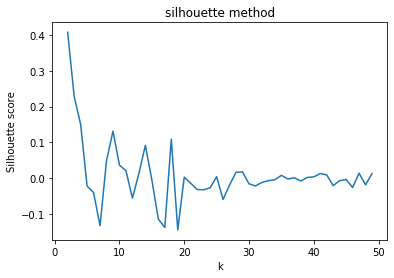

[20848.039948463265, 20724.073132548066, 19813.117021479844, 19431.535952901588, 19521.407062212867, 18824.636552990705, 18296.765982308523, 18024.201458351195, 17205.897919740346, 16745.58755076499, 16319.19359692992, 16428.85118506797, 15945.85862651021, 15424.574823673724, 15317.082334704777, 15042.455028697179, 14500.92136189614, 14295.224634360646, 13980.24765265689, 13571.055179164217, 13164.482067568442, 13040.412423616774, 12623.105478487061, 12200.11996980563, 12241.43889834772, 11563.78820846069, 11243.549779114406, 11097.252974667981, 10811.000786408418, 10567.832741553628, 10150.038880084938, 10007.421759235094, 9674.494454452913, 9422.693897326357, 9229.824944742486, 9094.092489341734, 8916.909002065375, 8493.163401927353, 8223.631089652474, 7908.332370185799, 7724.071235815994, 7564.162899132073, 7434.466035674892, 7084.827350834581, 6902.688001458022, 6729.430230064394, 6417.33652332573, 6339.220819307815]


In [52]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
import matplotlib.pyplot as plt
silhouette = []
SSQ = []
K=range(2,50)

df_grouped_clustering = df_grouped.drop('Neighbourhood', 1)

for k in K:
    mms=StandardScaler()
    mms.fit(df_grouped_clustering)
    X = mms.transform(df_grouped_clustering)
    km=KMeans(n_clusters=k,)
    km.fit(X)
    silhouette.append(silhouette_score(X,km.labels_))
    SSQ.append(km.inertia_)
    
plt.plot(K, silhouette,)
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('silhouette method')
plt.show()
print(SSQ)

In [49]:
# set number of clusters
kclusters = 5
N_INIT = 15



# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init = N_INIT).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 4, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [50]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [51]:
df_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged = df_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood', how = 'inner')

df_merged.head() # check the columns!

PostalCode      Borough                         Neighbourhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3        M1G  Scarborough                                Woburn  43.770992   
4        M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  Cluster Labels       1st Most Common Venue  \
0 -79.194353               3        Fast Food Restaurant   
1 -79.160497               0  Construction & Landscaping   
2 -79.188711               0           Electronics Store   
3 -79.216917               0                 Coffee Shop   
4 -79.239476               0                      Bakery   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                 Field        Farmers Market    Falafel Restaurant   
1                   Bar           Yoga Studio          Dessert Shop   
2        Breakfast Spot           Pizza Place        Medical Center   
3     Korean Restaurant          Dessert Shop  Fast Food Restaurant   
4                  Bank      Hakka Restaurant   Fried Chicken Joint   

  5th Most Common Venue        6th Most Common Venue 7th Most Common Venue  \
0     Electronics Store  Eastern European Restaurant             Drugstore   
1  Fast Food Restaurant               Farmers Market    Falafel Restaurant   
2    Mexican Restaurant                 Intersection   Rental Car Location   
3        Farmers Market           Falafel Restaurant     Electronics Store   
4    Athletics & Sports              Thai Restaurant  Caribbean Restaurant   

         8th Most Common Venue        9th Most Common Venue  \
0                      Dog Run               Discount Store   
1            Electronics Store  Eastern European Restaurant   
2             Department Store  Eastern European Restaurant   
3  Eastern European Restaurant                    Drugstore   
4               Discount Store                        Diner   

  10th Most Common Venue  
0                  Diner  
1              Drugstore  
2              Drugstore  
3                Dog Run  
4            Yoga Studio

visualize the resulting clusters

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'],df_merged['Neighbourhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Examine Clusters

#### Cluster 1

In [54]:
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

Borough  Cluster Labels       1st Most Common Venue  \
1         Scarborough               0  Construction & Landscaping   
2         Scarborough               0           Electronics Store   
3         Scarborough               0                 Coffee Shop   
4         Scarborough               0                      Bakery   
6         Scarborough               0              Discount Store   
7         Scarborough               0                    Bus Line   
8         Scarborough               0         American Restaurant   
9         Scarborough               0             College Stadium   
10        Scarborough               0           Indian Restaurant   
11        Scarborough               0              Breakfast Spot   
12        Scarborough               0                      Lounge   
13        Scarborough               0                 Pizza Place   
15        Scarborough               0        Fast Food Restaurant   
17         North York               0    Mediterranean Restaurant   
18         North York               0              Clothing Store   
19         North York               0          Chinese Restaurant   
22         North York               0            Ramen Restaurant   
24         North York               0                    Pharmacy   
26         North York               0        Gym / Fitness Center   
27         North York               0                         Gym   
28         North York               0                 Coffee Shop   
29         North York               0                 Coffee Shop   
32         North York               0                  Food Truck   
33         North York               0                Liquor Store   
34         North York               0                 Coffee Shop   
35          East York               0                 Pizza Place   
36          East York               0                    Pharmacy   
37       East Toronto               0        Other Great Outdoors   
38          East York               0                 Coffee Shop   
39          East York               0           Indian Restaurant   
41       East Toronto               0            Greek Restaurant   
42       East Toronto               0                         Pub   
43       East Toronto               0                        Café   
45    Central Toronto               0                         Gym   
46    Central Toronto               0              Clothing Store   
47    Central Toronto               0                Dessert Shop   
48    Central Toronto               0                         Gym   
49    Central Toronto               0                 Coffee Shop   
51   Downtown Toronto               0                        Café   
52   Downtown Toronto               0                   Bookstore   
53   Downtown Toronto               0                 Coffee Shop   
54   Downtown Toronto               0                        Café   
55   Downtown Toronto               0                   Gastropub   
56   Downtown Toronto               0              Farmers Market   
57   Downtown Toronto               0                 Coffee Shop   
58   Downtown Toronto               0            Asian Restaurant   
59   Downtown Toronto               0                        Café   
60   Downtown Toronto               0                 Coffee Shop   
61   Downtown Toronto               0                        Café   
62         North York               0                 Coffee Shop   
63    Central Toronto               0     Health & Beauty Service   
65    Central Toronto               0                        Café   
66   Downtown Toronto               0                      Bakery   
67   Downtown Toronto               0                        Café   
68   Downtown Toronto               0              Airport Lounge   
69   Downtown Toronto               0                Cocktail Bar   
70   Downtown Toronto               0                 Coffee Shop   
71         N

#### Cluster 2

In [55]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
23         North York               1                  Park   
25         North York               1                  Park   
30         North York               1               Airport   
31         North York               1         Grocery Store   
40          East York               1           Coffee Shop   
44    Central Toronto               1                  Park   
50   Downtown Toronto               1                  Park   
64    Central Toronto               1                  Park   
72         North York               1           Pizza Place   
74               York               1                  Park   
79         North York               1         Deli / Bodega   
90          Etobicoke               1                 River   
94          Etobicoke               1                  Bank   
98               York               1                  Park   
100         Etobicoke               1           Pizza Place   

    2nd Most Common Venue       3rd Most Common Venue 4th Most Common Venue  \
23      Convenience Store                        Bank           Yoga Studio   
25      Food & Drink Shop                 Yoga Studio      Department Store   
30                   Park                 Yoga Studio      Department Store   
31                   Park               Shopping Mall                 Hotel   
40                   Park           Convenience Store      Department Store   
44            Swim School                    Bus Line           Yoga Studio   
50             Playground                       Trail              Building   
64                  Trail               Jewelry Store      Sushi Restaurant   
72                   Park                         Pub   Japanese Restaurant   
74                 Market               Women's Store  Fast Food Restaurant   
79                   Park  Construction & Landscaping                Bakery   
90                   Park                  Smoke Shop           Yoga Studio   
94            Yoga Studio                Dessert Shop  Fast Food Restaurant   
98            Yoga Studio            Department Store        Farmers Market   
100                  Park           Mobile Phone Shop              Bus Line   

    5th Most Common Venue        6th Most Common Venue  \
23           Dessert Shop               Farmers Market   
25         Farmers Market           Falafel Restaurant   
30         Farmers Market           Falafel Restaurant   
31                   Bank                  Yoga Studio   
40         Farmers Market           Falafel Restaurant   
44       Department Store           Falafel Restaurant   
50            Yoga Studio             Department Store   
64            Yoga Studio             Department Store   
72            Yoga Studio                Deli / Bodega   
74       Department Store               Farmers Market   
79           Dessert Shop               Farmers Market   
90      Electronics Store  Eastern European Restaurant   
94         Farmers Market           Falafel Restaurant   
98     Falafel Restaurant            Electronics Store   
100           Yoga Studio             Department Store   

           7th Most Common Venue        8th Most Common Venue  \
23            Falafel Restaurant            Electronics Store   
25             Electronics Store  Eastern European Restaurant   
30             Electronics Store  Eastern European Restaurant   
31              Department Store           Falafel Restaurant   
40             Electronics Store  Eastern European Restaurant   
44             Electronics Store  Eastern European Restaurant   
50            Falafel Restaurant            Electronics Store   
64            Falafel Restaurant            Electronics Store   
72             Electronics Store  Eastern European Restaurant   
74            Falafel Restaurant            Electronics Store   
79            Falafel Restaurant            Electronics Store   
90                     Drugstor

#### Cluster 3

In [56]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
21  North York               2             Piano Bar                 Field   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
21        Farmers Market    Falafel Restaurant     Electronics Store   

          6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
21  Eastern European Restaurant             Drugstore               Dog Run   

   9th Most Common Venue 10th Most Common Venue  
21        Discount Store                  Diner

#### Cluster 4

In [57]:
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0   Scarborough               3  Fast Food Restaurant                 Field   
80         York               3  Fast Food Restaurant                   Bar   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Farmers Market    Falafel Restaurant     Electronics Store   
80        Sandwich Place            Restaurant           Yoga Studio   

          6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0   Eastern European Restaurant             Drugstore               Dog Run   
80             Department Store    Falafel Restaurant     Electronics Store   

          9th Most Common Venue 10th Most Common Venue  
0                Discount Store                  Diner  
80  Eastern European Restaurant              Drugstore

#### Cluster 5

In [58]:
df_merged.loc[df_merged['Cluster Labels'] == 4, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
5   Scarborough               4            Playground           Yoga Studio   
14  Scarborough               4            Playground                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5          Deli / Bodega        Farmers Market    Falafel Restaurant   
14           Yoga Studio         Deli / Bodega    Falafel Restaurant   

   6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
5      Electronics Store  Eastern European Restaurant             Drugstore   
14     Electronics Store  Eastern European Restaurant             Drugstore   

   9th Most Common Venue 10th Most Common Venue  
5                Dog Run         Discount Store  
14               Dog Run         Discount Store

## Thank you for going through my notebook. 